In [2]:
###############################################
#
#      BIGRAM LLM build with a Neural Network
#
###############################################

import torch
import matplotlib.pyplot as plt

with open('names.txt', 'r') as file:
    names = file.readlines()
names = [name.strip().lower() for name in names] # only lowercase letters to get 26 chars

SPECIAL_CH = '.'

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)} # {'a':1, 'b':2, 'c':3, ..., 'z':26}
# print(stoi)
stoi[SPECIAL_CH] = 0
itos = {i:s for s, i in stoi.items()}

# include counting the special char with the chars in the dataset - 27 total
NUM_CHARS = len(chars + [SPECIAL_CH])

# create a training set of bigrams ( x (1st char),y (2nd char) )

# inputs (xs) and targets (ys)
xs, ys = [], []

for name in names[:1]:
    chs = [SPECIAL_CH] + list(name) + [SPECIAL_CH]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1] # get the number for the char from the stoi dict
        ix2 = stoi[ch2]
        xs.append(ix1) # first chars
        ys.append(ix2) # second chars

# create tensors from the lists of bigrams assembled
xs = torch.tensor(xs) # note: use lowercase tensor() not Tensor() - that one forces the dtype to be float and lowercase tensor() infers the datatype
ys = torch.tensor(ys)

print(f'Int representation of first chars: {xs}') # inputs
print(f'Int representation of second chars: {ys}') # labels (targets)
# When xs[i] (first chars in bigram) is entered we want ys[i] (second chars in bigram) to have a high probability: example: When 0 is entered we want 5 to have a high probability

Int representation of first chars: tensor([ 0,  5, 13, 13,  1])
Int representation of second chars: tensor([ 5, 13, 13,  1,  0])


Unencoded Inputs: tensor([ 0,  5, 13, 13,  1])

Encoded shape: torch.Size([5, 27])
torch.float32

Onehot encoded inputs (xenc): tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])


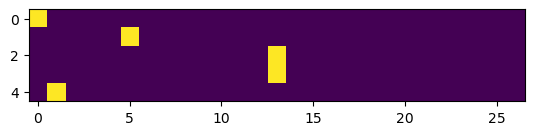

In [20]:
###################
# ONE HOT ENCODING
###################

# Not ideal to pass in integers to neural networks (due to calculations on floats), so we use One Hot Encoding
# We want float values for a nueral net so they can take on various/continuous values
# create a vector made up of dimensions matching the integer and turn the i-th element (the integer index) into a 1
# This vector can feed into a neural net

import torch.nn.functional as F

print(f'Unencoded Inputs: {xs}\n')
# one hot encoding. Pass in the integers you want to encode. num_classes is how many elements in the vector
xenc = F.one_hot(xs, num_classes=NUM_CHARS) # we only need 27 elements in the vector representing 26 letters of the dataset and 1 special token '.'
print(f'Encoded shape: {xenc.shape}') # [5,27] one row for each letter, 27 elements in each vector
# print(xenc.dtype) # int64 - caution!

# cast the returned type from one_hot() to a float (it returns int64 integers, but we need floats to feed into neural nets)
xenc = xenc.float()
print(xenc.dtype)
print(f'\nOnehot encoded inputs (xenc): {xenc}')

plt.imshow(xenc) # visualize the one hot encoded chars
plt.show()

# each row is an example that can be fed into a neural net. The appropriate bit is turned on as a 1 (yellow block) and everything else is 0 (purple blocks)

In [4]:
########## Feed Input into Neurons ##############

# Generate Weights
W = torch.randn((NUM_CHARS,1)) # normally distributed numbers - most will be around 0, and the tails are thin around magnitude of 3,-3
print(f'Weights: {W}\n') # Column vector of 27 (NUM_CHARS) numbers - these will be multiplied by the inputs

# multiply the encoded inputs by the weights using matrix multiplication
print(f'xenc@W: {xenc @ W}\n')


### How matrix multiplication works ###

# matrix multiplication of [5, 27] @ [27, 1] takes the 27 cols of input bits (per row) and multiplies by the 27 rows of W (one weight copied 27 times to fill out each row) and takes the sum (dot product)
  # the col values in each of the 5 rows represent the 27 characters and which character is "turned on" - the bit as seen in the above xenc output
# this shows us the five activations on this neuron depending on each of the 5 inputs

turned_on_indices = torch.where(xenc>0) # first tensor = which row, second tensor = which col
print(f'{turned_on_indices=}\n')

# Matrix multiplication goes for all the values in the xenc row, they are multplied by each col value in W in this case (since there is only 1 column each row val goes down the vals element-wise))
  # Most of the values per row in xenc are 0 until we find the bit representing the char that is turned on. This will be a 1. and will be multiplied by the corresponding col value in W - 
  # the sum of the dotproduct will match 1xWcol_val since we only have one col in W
# xenc[0][0] x W[0][0]
# xenc[0][1] x W[1][0]
# xenc[0][2] x W[2][0]
# ...

r = turned_on_indices[0]
c = turned_on_indices[1]
print(f'First char bit turned on (={xenc[r[0]][c[0]]}): row={r[0]},col={c[0]} = corresponding weight val {W[c[0]][0]:.4f} = row {c[0]} in W')
print(f'Second char bit turned on (={xenc[r[1]][c[1]]}): row={r[1]},col={c[1]} = corresponding weight val {W[c[1]][0]:.4f} = row {c[1]} in W')


Weights: tensor([[ 1.2485],
        [ 2.0891],
        [ 1.3456],
        [-0.4979],
        [-0.6950],
        [-1.6033],
        [ 0.5910],
        [ 0.6191],
        [-0.2044],
        [-1.7460],
        [-1.0895],
        [-0.3859],
        [ 0.4117],
        [ 1.1640],
        [-1.0882],
        [ 1.1278],
        [-1.1210],
        [ 1.0186],
        [-0.8420],
        [-1.0710],
        [-0.1950],
        [-0.5454],
        [ 1.3963],
        [ 0.5151],
        [ 0.0240],
        [-0.6053],
        [-0.5335]])

xenc@W: tensor([[ 1.2485],
        [-1.6033],
        [ 1.1640],
        [ 1.1640],
        [ 2.0891]])

turned_on_indices=(tensor([0, 1, 2, 3, 4]), tensor([ 0,  5, 13, 13,  1]))

First char bit turned on (=1.0): row=0,col=0 = corresponding weight val 1.2485 = row 0 in W
Second char bit turned on (=1.0): row=1,col=5 = corresponding weight val -1.6033 = row 5 in W


In [ ]:
# The above is for one neuron, but we want more neurons which represent one layer in a neural net

####### GENERATE WEIGHTS FOR NEURONS #######
# Define the weights - use random nums - each nueron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
# W is random normal distribution between -3 and 1
W = torch.randn((NUM_CHARS, NUM_CHARS), generator=g) # 27x27 - first arg is the column of weight values to use, the second argument represents the number of neurons
# [ [...weights], [...for which neuron] ] - rows = weights, cols = neurons
# print('W')
# print(W[:,2])

dot_prods = xenc @ W # now we have a 5x27 matrix (the five onehot encoded inputs to the NN multiplied by  )

# this shows the dot product of the third input and the 13th column of the W (weights) matrix
print(f'Firing rate of 14th neuron looking at 4th input (row): {dot_prods[3,13]}\n')
# the firing rate is the dot product of that intput (the row values of xenc) multiplied by the weights (column values) for that neuron:
print(f'xenc 4th row: {xenc[3]}\n')
print(f'W 14th column: {W[:,13]}')
print(f'\nRegular Product of 4th col of xenc ({xenc[3,13]}) and 14th col of W ({W[:,13][13]}): {(xenc[3] * W[:,13])}')
print(f'\n4th col of xenc multiplied by 14th col of W with pytorch @ operator: {xenc[3] @ W[:,13]}')
print(f'Manual calcd Dot product of 4th input against 14th col of W: {(xenc[3] * W[:,13]).sum()}') # should match firing rate printed above

### This matrix multiplication allows us to look at multiple input examples input into a layer of neurons in a neural net (i.e. 27 inputs into a layer of 27 neurons here)
## NOTE: This layer is a linear layer (there is no bias or squashing function like tanh applied, just weights x inputs).
        # This NN is also going to be just one layer (as simple as possible NN)

print(f'\nInputs x Weights (27 neurons): {dot_prods}')

W


NameError: name 'dot_prods' is not defined

In [6]:
########### EXPONENTIATION TO USE FOR GETTING LOG COUNTS OF CHARACTERS ###################


'''
We need a probability distribution for what the next character could be given a character input.

Because integers are not ideal in NN input, we cannot use integer counts per char (as in the original non-neural net example of a bigram - see ./bigramllm.ipynb).
We therefore use log counts (i.e. 'logits') - we use exponentiatiation of the weight x input dot product outputs of the neural layer to get the log counts.

Exponentation: see https://www.wolframalpha.com/input?i=exp%28x%29

If negative number input, you will get e^x which is always positive and below +1
If positive number input, you get numbers greater than +1 to positive infinity

We can use this exponentiated log count to represent the count per character that we used originally.
'''

print('exponentiated values -3.0 and 5.0:')
t = torch.tensor([-3.0,5.0])
print(t.exp()[0].item()) # exponentiation: negative input results in positive number below 1
print(t.exp()[1].item()) # exponentiation: positive input results in positive number even higher than the input (and greater than 1)
print('\n')


exponentiated values -3.0 and 5.0:
0.049787066876888275
148.4131622314453




In [7]:
# Get the log counts for the neural net layer:
logits = xenc @ W # log-counts (the inputs, which bit is on representing the character in the set, multiplied by the weights - each col is the dot product per neuron in the layer)
counts = logits.exp() # exponentiated logits: make any negatives positive (to better represent counts), this is equivalent to and can be interpreted as the counts per char
print(f'All counts: {counts}') # all will be positive numbers due to the exponentation of the dot product outputs (if they were negative)
# NOTE: all of these are differentiable operations that we can back propagate through (i.e. use gradient descent)

s = counts.sum(1, keepdim=True) # get sum per row (1st dimension)
print(f'\nSum of counts per row: {s}')

# Probabilities using the count normalized by the sum of counts in the row:
probs = counts / counts.sum(1, keepdim=True)
print(f'\nProbabilities (count / row_sum): {probs}') # every row sums to 1.0


All counts: tensor([[ 4.7940,  0.7888,  0.9730,  0.3326,  1.3309,  0.9708,  0.2129,  1.8311,
          1.0824,  2.4710,  0.6242,  2.1964,  0.7200,  0.6486,  3.9469, 18.7908,
          4.7673,  0.1967,  1.9683,  0.4315,  2.6775,  0.8621,  0.2277,  1.5656,
          0.9317, 12.1434, 11.5281],
        [ 1.6038,  4.4060,  1.3737,  2.8830, 11.0032,  1.5972,  0.5187,  1.8527,
          0.5369,  1.6654,  3.8818,  1.2642,  0.6339,  0.9987,  0.5995,  1.7432,
          1.6073,  0.2499,  5.0680,  1.1876,  2.6871,  1.6596,  2.7728,  0.1486,
          0.6521,  0.1193,  2.6128],
        [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
          4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5719,  0.4373,
          2.2763,  0.4719,  2.5289,  0.2265,  0.8082,  0.3054,  0.5164,  0.7918,
          4.6866,  1.8232,  0.4921],
        [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
          4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5

In [8]:
# we now have 27 numbers for each input (i.e. a single char fed into the neural net)
i = 0 # first row representing the input of the first character `.` - xs[0]
print(f'Input char: {itos[i]}')
print(f'Probabilities of which char comes after char input: \n\t{[round(n.item(), 4) for n in probs[i]]}\n')
print(probs[i].sum()) # normalized to probs so they all sum to 1.0



Input char: .
Probabilities of which char comes after char input: 
	[0.0607, 0.01, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137, 0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.05, 0.2378, 0.0603, 0.0025, 0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459]

tensor(1.0000)


In [9]:
############################################
#
#        PUTTING IT ALL TOGETHER
# Using a Nueral Network to predict Bigrams
#
############################################

# Example training set, i.e. '.emma.'
print(f'Inputs: {xs}')
print(f'Targets (Labels): {ys}\n')
# first input is the character and the labels are what come after it in this example
#  i.e. 'emma' is '.e em mm ma a.' 
  # if we feed in '.' we expect to get 'e' as the next char from the NN

#########################
#   INITIALIZE WEIGHTS
#########################
# Define the weights - use random nums - each nueron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)

# Start with a RANDOM count for all of the characters! (Loss is then guided down via gradient descent from this random starting point)
W = torch.randn((NUM_CHARS, NUM_CHARS), generator=g, requires_grad=True) # we need to tell pytorch we are interested in calculating the gradient for the tensor

Inputs: tensor([ 0,  5, 13, 13,  1])
Targets (Labels): tensor([ 5, 13, 13,  1,  0])



In [10]:
#########################
#      FORWARD PASS 
#########################

# NOTE: these are all differentiable operations that we can back propagate through
  # Addition, Multiplication, Division, Summing, Exponentiation


### Architecture of this Neural Net: 1 Layer followed by soft-max activation function

# One-hot encode the inputs
xenc = F.one_hot(xs, num_classes=NUM_CHARS).float()
logits = xenc @ W # log-counts

# these two operations represent 'soft-max'
  # soft-max is a activation function used to normalize and convert to outputting probability distributions (all vals sum to 1.0)
  # This is something you can put on top of any layer in a NN and it makes the layer output probabilities
counts = logits.exp() # e^{log count} - forces to be positive etc.
probs = counts / counts.sum(1, keepdims=True) # probabilities for next char - normalize with division as part of the soft-max activation function
# 5x27 matrix - vector of probabilities that sum to 1.0 for each example input

### CALCULATE LOSS ###
# For classification as we're doing here (instead of regression as in the basic example in NeuralNetworks/neural_network.ipynb), use negative log likelihood for the loss calculation instead of means squared error
# get the probabilities we want to update from the output which are assigned by the NN currently to the next probable characters given the input
next_char_probs = probs[torch.arange(5), ys] # for each example input row pluck the probability we're interested in of the next expected char
# get the log probability and average down with the mean
loss = -next_char_probs.log().mean() # this is the negative log likelihood

#########################
#      BACKWARD PASS 
#########################

# set the gradient to 0 before backward pass
W.grad = None # more efficient way in pytorch to zero out the gradient

# use torches .backward() to back propagate the loss to fill in the gradients all the way back from the Loss through the operations to the Weights W tensor
loss.backward() # make sure you included requires_grad=True on your Weights tensor
print(f'Loss: {loss.item()}')

# Gradient matrix and Weights matrix have the same shape - every element is telling us what the gradient of the weight is and how it affects the loss
# We can now use the gradients to adjust the weights in the opposite direction to lower the loss
# print(W.grad) # shows gradients for each weight to reduce loss
# W.shape
# W.grad.shape

#########################
#      UPDATE WEIGHTS 
#########################

W.data += -0.1 * W.grad # updates all the weights against the gradient from back propagation
# We now expect the loss to decrease after doing another forward pass

Loss: 3.7693049907684326


In [11]:
### Important point: 
# The bigram matrix is initialized randomly to begin with
# The loss guides the counts to be filled in via gradient descent

In [ ]:
######## REGULARIZATION ############

# Take W char counts matrix and square the values to eliminate signs and take the sum
# You get 0 loss if W is 0, and accumulate loss if W has non-zero numbers in it
# see timestamp 1:50:49 in https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2
# and timestamp 1:51:17 in https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3
# Explanation of regularization at timestamp 1:52:25 in https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3

# This is equivalent to smoothing, but using in the context of Gradient Descent approach.
# Getting all the counts initialized in W to 0 (this makes them all 1 when exponentiated), makes the distribution uniform (all counts have equal probability)
# The idea is to get the distribution to be uniform

print((W**2).sum().item())
# You can use mean as well if the sum gives you numbers that are too large
print((W**2).mean().item())


# You can then set the strength of this regularization and add it to the loss function as an extra optimization component.
0.01*(W**2).mean()
# It acts as a "spring force" to push the values of W towards 0 (to get a uniform distribution) while the loss is trying to make the probabilities work out (?)
  # If Ws are 0, you achieve 0 loss
  # If Ws are not 0, then you feel a loss (accumulates loss due to W**2 sum/mean above)
  # Ws want to be 0 to be uniform (no loss), but also match up to the probabilities of the data (??)




# This is equivalent to the Smoothing done in bigramllm.ipynb
# The regularization strength is the same as how many counts you add (i.e. +1 or higher to get more uniform distribution) in the example below
  # If the regularization strength is too high, then everything will become uniform predictions


##################
#    Smoothing From bigramllm.ipynb
##################

# convert all values to float as we used to do for the loop
# P = (N+1).float() # add 1 or higher value to all values in the dataset - removes any 0s from the dataset
# This removes 0 values (makes them 1 or higher) and is a nicety when measuring the likelihood since it will prevent values with 0 probability resulting showing infinity in the loss function (i.e. negative log likelihood)
# The higher the value you add, the more smooth your model will be, the lower the value will have more peaks etc.


# Further Explanation:
# we want smoothing because it enables the model to still predict the never-seen combinations 
# (there should be some chance a bigram, for example, that has 0 counts in the training set, will still be included in the predictions)

# Just like andrej discussed about the 'jq' example in the video. 
# 'jq' combination was never in the training data but we want the model to have some probability of predicting it no matter how low. 

# This is achieved in a neural network approach by pushing W to be near 0 and not letting it grow too much. 
# Because, when W is near to zero, logits is near to zero, therefore making logits.exp() near to 1.
# Ultimately this makes all the probablities equal making all the combinations have the same chance to appear. 

# This is why we added regularization. By adding W to loss function, we are making the loss grow with W growing. 
# Since backward prop tries to decrease the loss, it doesnt let W grow.



704.4127197265625
0.9662725925445557


In [ ]:
############ COMPLETE ITERATIVE IMPLEMENTATION OF THE MODEL ##############

import torch
import torch.nn.functional as F

# create the dataset
with open('names.txt', 'r') as file:
    names = file.readlines()
names = [name.strip().lower() for name in names] # only lowercase letters to get 26 chars

SPECIAL_CH = '.'

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)} # {'a':1, 'b':2, 'c':3, ..., 'z':26}
stoi[SPECIAL_CH] = 0
itos = {i:s for s, i in stoi.items()}

NUM_CHARS = len(chars + [SPECIAL_CH])

xs, ys = [], []
for name in names:
    chs = [SPECIAL_CH] + list(name) + [SPECIAL_CH]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1) 
        ys.append(ix2)
xs = torch.tensor(xs) # first chars of each pair from dataset - one dimensional array [0,5,13,13,1,...]
ys = torch.tensor(ys) # chars following the first char from the pairs
num_chars_to_sample = xs.nelement()
print('number of examples: ',num_chars_to_sample) # how many chars to sample predictions for    

# Initialize Network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((NUM_CHARS,NUM_CHARS), generator=g, requires_grad=True) # start with random weights

# print(F.one_hot(xs, num_classes=NUM_CHARS).float())
# print(xs)

############################################ 
#               GRADIENT DESCENT           # 
# ##########################################

for k in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes=NUM_CHARS).float() # one hot encode the input to the network - each row (one row per char) is 0s with the integer to str mapping idx set as 1
    logits = xenc @ W # logits is the appropriate row of W to find the counts/prob for that char/pair. W is the log counts. (the original bigram table with the counts would be W exponentiated - W.exp())
    counts = logits.exp() # make all positive - e^x, vals close to zero will be close to 1
    probs = counts / counts.sum(1, keepdims=True) # probability for next char
    regularization_strength = 0.01 # can adjust this strength. the higher it is the more smooth it makes the distribution (more uniform). If higher it dominates the loss fn below and will make the weights (W) unable to grow because too much loss will be accumulated. everything will become uniform distribution equal predictions (?)
    loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + regularization_strength*(W**2).mean() # regularizatization wants to push towards 0
    print(f'LOSS: {loss.item()}') # we should see the loss decreasing

    ######### BACKWARD PASS ###############
    # Zero the gradient
    W.grad = None
    loss.backward()

    ######### UPDATE THE WEIGHTS #############
    learning_rate = 50 # if slow loss reduction, increase the learning rate to bring it down faster
    
    W.data += -learning_rate * W.grad # go in reverse direction of gradient with the goal of reducing loss


    # Note: the W matrix of counts (log counts) when exponentiated is the same as the Bigram grid in bigramllm.ipynb
    # ***** Where in bigramllm.ipynb the Matrix was created by manually getting counts, here the W matrix with the same counts was arrived at via following the loss and adjusting during gradient descent ******
    

number of examples:  783
LOSS: 3.761927366256714
LOSS: 3.2758822441101074
LOSS: 3.0034070014953613
LOSS: 2.8422064781188965
LOSS: 2.7362682819366455
LOSS: 2.660226821899414
LOSS: 2.6021833419799805
LOSS: 2.555994987487793
LOSS: 2.518109083175659
LOSS: 2.486332416534424
LOSS: 2.4592206478118896
LOSS: 2.435776948928833
LOSS: 2.4152884483337402
LOSS: 2.3972320556640625
LOSS: 2.3812108039855957
LOSS: 2.366915702819824
LOSS: 2.354097843170166
LOSS: 2.3425540924072266
LOSS: 2.332115411758423
LOSS: 2.322638511657715
LOSS: 2.3140017986297607
LOSS: 2.306100368499756
LOSS: 2.2988433837890625
LOSS: 2.2921531200408936
LOSS: 2.2859628200531006
LOSS: 2.280214309692383
LOSS: 2.274858236312866
LOSS: 2.2698514461517334
LOSS: 2.265158176422119
LOSS: 2.260746955871582
LOSS: 2.256589651107788
LOSS: 2.2526631355285645
LOSS: 2.248947858810425
LOSS: 2.245424509048462
LOSS: 2.242079019546509
LOSS: 2.238896369934082
LOSS: 2.2358651161193848
LOSS: 2.23297381401062
LOSS: 2.2302134037017822
LOSS: 2.22757482528686

In [49]:
# t = torch.tensor([1,2,-10,-.001])
# torch.set_printoptions(precision=6, sci_mode=False)
# print(t.exp())

# torch.set_printoptions(profile="default")

tensor([    2.718282,     7.389056,     0.000045,     0.999000])


In [1]:
###### SAMPLE FROM THE NEURAL NET MODEL ######

g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0

    while True:
        # plucks out the row of W corresponding to ix - will be the first char, then the char predicted, and the char predicted after that..etc..
        xenc = F.one_hot(torch.tensor([ix]), num_classes=NUM_CHARS).float()
        logits = xenc @ W # one hot encoded char multiplied by the weights in W
        counts = logits.exp() # getting the exponentiated log counts for the chars

        p = counts / counts.sum(1, keepdims=True) # probabilities for next char

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # gets a char based on the probabilities calculated above
        out.append(itos[ix])

        if ix == 0:
            break

    print(''.join(out))

NameError: name 'torch' is not defined

In [ ]:
import torch
import torch.nn.functional as F

# missing ca bigram
with open('simple_missing_one_combo_in_dataset.txt', 'r') as file:
    names = file.readlines()
names = [name.strip().lower() for name in names] # only lowercase letters to get 26 chars

SPECIAL_CH = '.'

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i, s in enumerate(chars)} # {'a':1, 'b':2, 'c':3, ..., 'z':26}
stoi[SPECIAL_CH] = 0
itos = {i:s for s, i in stoi.items()}

NUM_CHARS = len(chars + [SPECIAL_CH])

xs, ys = [], []
for name in names:
    chs = [SPECIAL_CH] + list(name) + [SPECIAL_CH]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1) 
        ys.append(ix2)
xs = torch.tensor(xs) # first chars of each pair from dataset - one dimensional array [0,5,13,13,1,...]
ys = torch.tensor(ys) # chars following the first char from the pairs
num_chars_to_sample = xs.nelement()
print('number of examples: ',num_chars_to_sample) # how many chars to sample predictions for    

# Initialize Network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((NUM_CHARS,NUM_CHARS), generator=g, requires_grad=True) # start with random weights

# print(F.one_hot(xs, num_classes=NUM_CHARS).float())
# print(xs)

############################################ 
#               GRADIENT DESCENT           # 
# ##########################################

for k in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes=NUM_CHARS).float() # one hot encode the input to the network - each row (one row per char) is 0s with the integer to str mapping idx set as 1
    logits = xenc @ W # logits is the appropriate row of W to find the counts/prob for that char/pair. W is the log counts. (the original bigram table with the counts would be W exponentiated - W.exp())
    counts = logits.exp() # make all positive - e^x, vals close to zero will be close to 1
    probs = counts / counts.sum(1, keepdims=True) # probability for next char
    regularization_strength = 0.01 # can adjust this strength. the higher it is the more smooth it makes the distribution (more uniform). If higher it dominates the loss fn below and will make the weights (W) unable to grow because too much loss will be accumulated. everything will become uniform distribution equal predictions (?)
    loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + regularization_strength*(W**2).mean() # regularizatization wants to push towards 0
    print(f'LOSS: {loss.item()}') # we should see the loss decreasing

    ######### BACKWARD PASS ###############
    # Zero the gradient
    W.grad = None
    loss.backward()

    ######### UPDATE THE WEIGHTS #############
    learning_rate = 50 # if slow loss reduction, increase the learning rate to bring it down faster
    
    W.data += -learning_rate * W.grad # go in reverse direction of gradient with the goal of reducing loss
